In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import cv2

2023-12-03 19:09:45.889828: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 19:09:46.645215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
current_directory = os.getcwd()
print("Current working directory:", current_directory)
new_directory = '/home/valentin/Desktop/licenta-xray/Licenta-Data/chest_xray'
os.chdir(new_directory)

Current working directory: /home/valentin/Desktop/licenta-xray/Licenta-Models


In [3]:
train_pneumonia = 'train'
test_pneumonia = 'test'
valid_pneumonia = 'val'

In [4]:
train_directory = os.path.join(new_directory, train_pneumonia)
test_directory = os.path.join(new_directory, test_pneumonia)
valid_directory = os.path.join(new_directory, valid_pneumonia)
print(train_directory)

/home/valentin/Desktop/licenta-xray/Licenta-Data/chest_xray/train


In [6]:
def rescale_images_in_directory(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):  
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                if image is not None:
                    rescaled_image = image / 255.0

                    cv2.imwrite(image_path, rescaled_image * 255.0)

In [7]:
rescale_images_in_directory(train_directory)
rescale_images_in_directory(test_directory)
rescale_images_in_directory(valid_directory)

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_directory, target_size=(224,224), classes=['PNEUMONIA', 'NORMAL'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_directory, target_size=(224,224), classes=['PNEUMONIA', 'NORMAL'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_directory, target_size=(224,224), classes=['PNEUMONIA', 'NORMAL'], batch_size=10, shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
assert train_batches.n == 5216
assert valid_batches.n == 16
assert test_batches.n == 624

In [7]:
imgs, labels = next(train_batches)

In [8]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

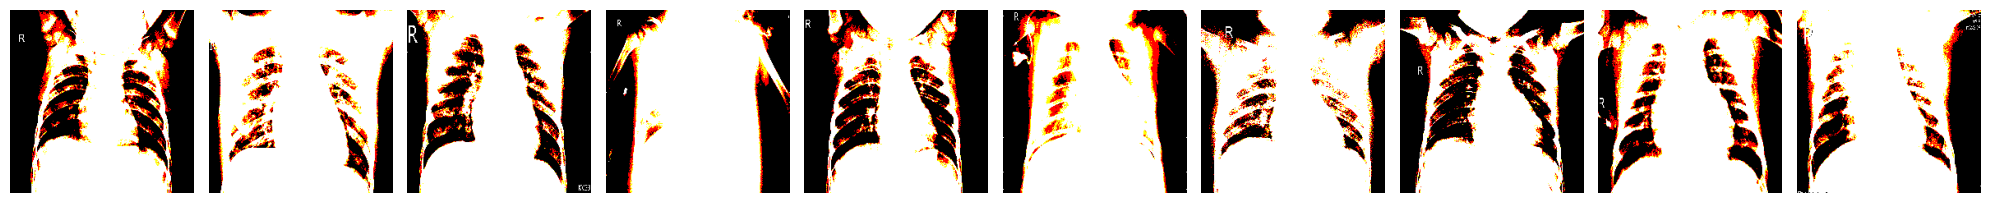

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [9]:
plotImages(imgs)
print(labels)


In [10]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

2023-12-03 19:09:57.107196: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-03 19:09:57.216634: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-03 19:09:57.216773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10


2023-12-03 19:09:59.870657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-03 19:10:00.973949: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-03 19:10:01.184889: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1ff5dde0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-03 19:10:01.184907: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 SUPER, Compute Capability 7.5
2023-12-03 19:10:01.215556: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-03 19:10:01.357387: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-03 19:10:01.427662: I ./tensorflow/compiler/jit/device_co

522/522 - 36s - loss: 1.7693 - accuracy: 0.9243 - val_loss: 0.2860 - val_accuracy: 0.9375 - 36s/epoch - 69ms/step
Epoch 2/10
522/522 - 26s - loss: 0.1070 - accuracy: 0.9810 - val_loss: 1.2693 - val_accuracy: 0.8125 - 26s/epoch - 50ms/step
Epoch 3/10
522/522 - 26s - loss: 0.0392 - accuracy: 0.9910 - val_loss: 0.4773 - val_accuracy: 0.8750 - 26s/epoch - 50ms/step
Epoch 4/10
522/522 - 26s - loss: 0.0184 - accuracy: 0.9946 - val_loss: 0.1454 - val_accuracy: 0.9375 - 26s/epoch - 50ms/step
Epoch 5/10
522/522 - 26s - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.0400 - val_accuracy: 1.0000 - 26s/epoch - 49ms/step
Epoch 6/10
522/522 - 27s - loss: 1.2589e-04 - accuracy: 1.0000 - val_loss: 0.0494 - val_accuracy: 1.0000 - 27s/epoch - 51ms/step
Epoch 7/10
522/522 - 26s - loss: 4.1533e-05 - accuracy: 1.0000 - val_loss: 0.0813 - val_accuracy: 0.9375 - 26s/epoch - 50ms/step
Epoch 8/10
522/522 - 26s - loss: 2.4292e-05 - accuracy: 1.0000 - val_loss: 0.0943 - val_accuracy: 0.9375 - 26s/epoch - 50ms/step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

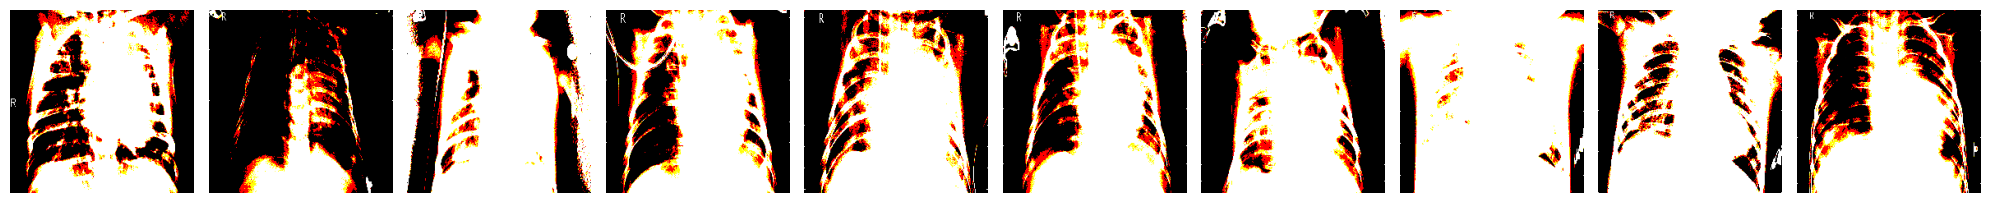

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [13]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [14]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [15]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [16]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[389   1]
 [166  68]]


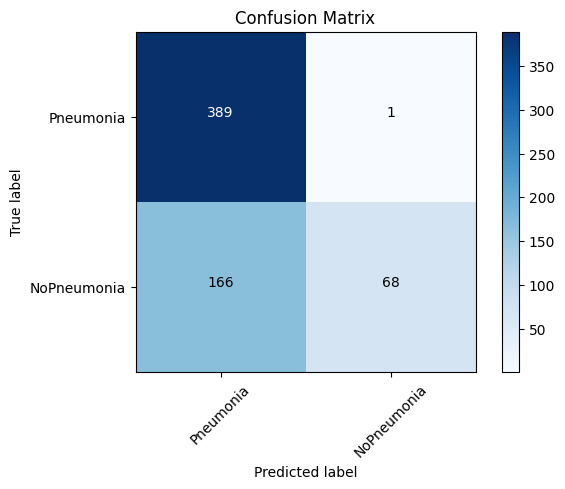

In [18]:
cm_plot_labels = ['Pneumonia','NoPneumonia']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [19]:
gen = ImageDataGenerator(rotation_range=3, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True)

In [20]:
chosen_image = random.choice(os.listdir('../Licenta-Data/Train/Chest/Pneumonia'))

FileNotFoundError: [Errno 2] No such file or directory: '../Licenta-Data/Train/Chest/Pneumonia'

In [21]:
image_path = '../Licenta-Data/Train/Chest/Pneumonia/' + chosen_image

NameError: name 'chosen_image' is not defined

In [22]:
assert os.path.isfile(image_path)

NameError: name 'image_path' is not defined

In [ ]:
image = np.expand_dims(plt.imread(image_path),0)

In [ ]:
plt.imshow(image[0])

In [ ]:
rgb_image = np.add(image, 3)
print(rgb_image.shape)
aug_iter = gen.flow(rgb_image)

In [ ]:
aug_iter = gen.flow(rgb_image)

In [ ]:
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

In [ ]:
plotImages(aug_images)

In [ ]:
for i in range(10):
    augmented_image = next(aug_iter)[0].astype(np.uint8)
    cv2.imwrite(f'../Licenta-Data/Train/Chest/Pneumonia/aug-image-{i}.jpeg', augmented_image)


In [ ]:
import os
directory_path = '../Licenta-Data/Train/Chest/Pneumonia'

image_files = os.listdir(directory_path)

batch_size = 1000
for batch_start in range(0, len(image_files), batch_size):
    batch_image_files = image_files[batch_start:batch_start + batch_size]

    for i, chosen_image in enumerate(batch_image_files):
        image_path = os.path.join(directory_path, chosen_image)

        if os.path.isfile(image_path):
            image = cv2.imread(image_path)

            augmented_images = [next(gen.flow(np.expand_dims(image, 0)))[0].astype(np.uint8) for _ in range(10)]

            for j, augmented_image in enumerate(augmented_images):
                save_path = os.path.join(directory_path, f'aug-image-{i}-{j}.jpeg')
                cv2.imwrite(save_path, augmented_image)

print("Augmentation complete for all images.")